# Image Registration

Image registration is a critical topic in computer vision, especially for aligning images taken at different times, from different viewpoints, or by different sensors.

You will work on an image registration problem based on landmark-based rigid registration. This allows you to understand the relationship between the transformation matrix, point correspondences, and the final warped image.

This exercise requires students to find the 3x3 rigid transformation matrix that maps corresponding points from a "moving" image to a "fixed" (target) image.

## Task 1. Define Corresponding Landmarks
You will manually select a minimum of two corresponding point pairs from the Moving Image and the Fixed Image.
Select Points: Use a tool (like a simple mouse click function or hardcoded coordinates for simplicity) to define corresponding points:$\mathbf{P} = [(x_{p1}, y_{p1}), (x_{p2}, y_{p2}), \dots]$ (Points in Moving Image)$\mathbf{Q} = [(x_{q1}, y_{q1}), (x_{q2}, y_{q2}), \dots]$ (Corresponding points in Fixed Image). To solve for a rigid transformation (rotation and translation), a minimum of two non-collinear point pairs is required.


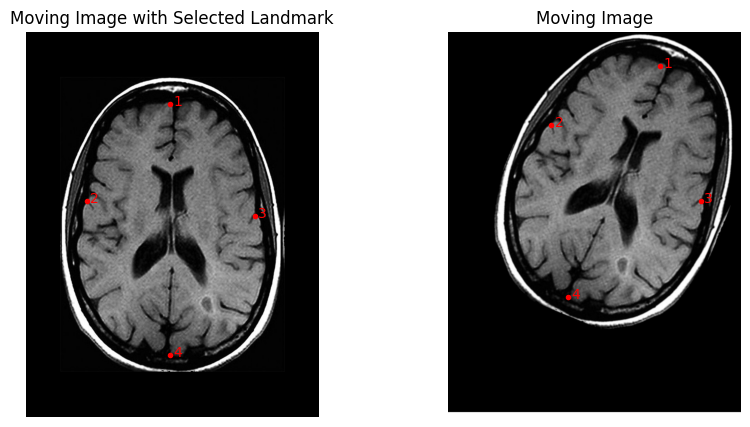

In [10]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.transform import estimate_transform
from cv2 import warpAffine


# --- EXECUTE POINT SELECTION ---
# Assuming img_fixed and img_moving are loaded [0, 1] images

img_fixed = skimage.io.imread('mri2_fixed.jpg', as_gray=True)
img_moving = skimage.io.imread('mri2_moving.jpg', as_gray=True)
fixed_landmarks = np.array([[411, 203], [173, 481], [651, 522], [411, 919]])
moving_landmarks = np.array([[602, 97], [293, 263], [718, 480], [340, 754]])

figure=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_fixed, cmap = 'gray')
plt.scatter(fixed_landmarks[:,0], fixed_landmarks[:,1], c='red',marker='.')
for i in range(fixed_landmarks.shape[0]):
    plt.text(fixed_landmarks[i,0] + 10, fixed_landmarks[i,1] + 5 , str(i+1), color='red')
plt.title("Moving Image with Selected Landmark")
plt.axis('off') 
plt.subplot(1,2,2) 
plt.imshow(img_moving, cmap ='gray')
plt.scatter(moving_landmarks[:,0],moving_landmarks[:,1],c='red',marker='.')
for i in range(moving_landmarks.shape[0]):
    plt.text(moving_landmarks[i,0] + 10, moving_landmarks[i,1] + 5, str(i+1), color='red')
plt.title("Moving Image") 
plt.axis('off') 
plt.show()

# --- Check the image mri2_fixed_landmarks.jpg and define the four points for P 
# P = np.array([[1, 2], [3, 4]]) 
# --- Open mri2_moving.jpg and look for the corresponding points and store them Q
# Q = np.array([[111, 96], [96, 111]])


## Task 2: Formulate and Solve the Linear System

The goal is to find the transformation parameters ($\theta, t_x, t_y$) embedded within the $3 \times 3$ transformation matrix $\mathbf{T}$. Since we have multiple points, we can set up a system of linear equations to find the parameters that minimize the error.HINT: A 2D rigid transformation from $\mathbf{p} = (x, y)$ to $\mathbf{q} = (x', y')$ can be written as:$$\begin{aligned}
x' &= x \cos\theta - y \sin\theta + t_x \\
y' &= x \sin\theta + y \cos\theta + t_y
\end{aligned}$$You can use the function skimage.transform.estimate_transform('rigid', P, Q).

In [11]:
# Your code here
# -----------------
# 2.1. YOUR CODE HERE: Estimate the Rigid Transformation
# -----------------
# You can use the function 'estimate_transform()' with the corresponding parameter for rigid transformations
src = fixed_landmarks 
dst = moving_landmarks 
T_matrix = estimate_transform('euclidean',src,dst)
# Then, extract the 3x3 Homogeneous Matrix
# T_matrix = tform.params
# print("Transformation Matrix T:\n", T_matrix)
print("Transformation Matrix T:\n", T_matrix)

Transformation Matrix T:
 <EuclideanTransform(matrix=
    [[   0.9274011 ,   -0.37406845,  305.34831234],
     [   0.37406845,    0.9274011 , -248.11099987],
     [   0.        ,    0.        ,    1.        ]])>


## Task 3: Apply Inverse Warping
The final step is to apply the transformation to the entire image using inverse warping (backward mapping). This requires the inverse of the transformation matrix, $\mathbf{T}^{-1}$.


(1095, 832)


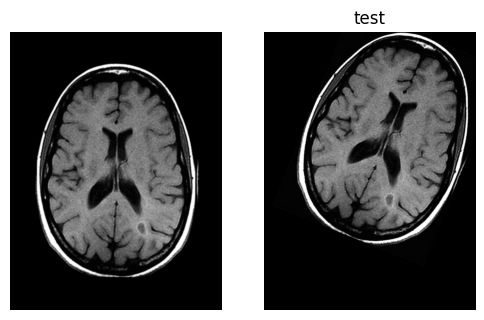

In [20]:
# Your code here
# Assume 'img_moving' is the source image.

# -----------------
# 3.1. YOUR CODE HERE: Calculate the Inverse Transformation Matrix
# -----------------
# You can use the function 'np.linalg.inv()'
T_inv= np.linalg.inv(T_matrix)
# 3.2. YOUR CODE HERE: Apply the Inverse Affine Transform (Registration)
# We use openCV's warpAffine() function for better performance. It takes
# - the moving image
# - the upper 2x3 part of the inverse transformation matrix
# - the output size as (width, height)
print(img_fixed.shape)
test= warpAffine(img_fixed, T_matrix.params[:2], img_moving.shape[::-1])

img_registered = warpAffine(img_moving, T_inv[:2], img_fixed.shape[::-1])
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(img_registered, cmap='gray')
plt.axis('off')
# plt.show()
plt.subplot(1,2,2) 
plt.imshow(test, cmap='gray')
plt.title('test') 
plt.axis('off')
plt.show()

###  (Optional) Calculate Error- Root Mean Square Error (RMSE) 
The RMSE is a normalized version of the SSD, which is easier to interpret as it gives the "average" magnitude of the error per pixel in the original intensity units.$$RMSE = \sqrt{\frac{1}{N} \sum_{y} \sum_{x} [I_F(x, y) - I_R(x, y)]^2}$$Interpretation: RMSE gives you the average difference between corresponding pixels. If the images are 8-bit (0-255), an RMSE of 10 means the average pixel difference is 10 intensity units.

In [24]:
# 3.3. Calculate the Root Mean Square Error (RMSE), which is the Euclidean distance between the two images, normalized by the number of pixels.
# Calculate the squared difference at every pixel

def rsme(img1,img2):
    diff = img1- img2
    squared_diff = diff* 2
    mse = np.mean(squared_diff) 
    rmse = np.sqrt(mse) 
    return rmse

rmse_value = rsme(img_fixed, img_registered) 
print("RMSE between fixed and registered Image", rmse_value)

RMSE between fixed and registered Image 7.703960089054251


## Task 4: Visualization (Image Fusion)
Visualize the quality of the registration.
Display the fixed image, registered image, and the combination of the registered image with the fixed image using the function 'blend_images()' below. If alignment is perfect, the fused image should look clean and sharp.


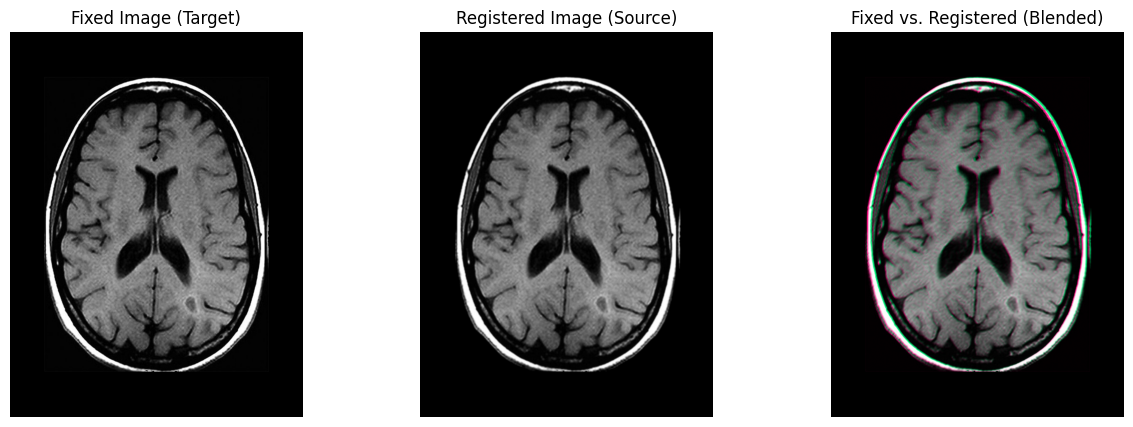

In [25]:
# --- Display Code (Do Not Modify) ---
# Create a checkerboard or blended image to show alignment quality
def blend_images(img1, img2):
    # Overlay the registered image (green) onto the fixed image (red)
    blended = np.stack([img1, img2, img1 / 2 + img2 / 2], axis=-1)
    return np.clip(blended, 0, 1)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Fixed Image (Target)')
plt.imshow(img_fixed, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Registered Image (Source)')
plt.imshow(img_registered, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Fixed vs. Registered (Blended)')
plt.imshow(blend_images(img_fixed.astype(np.float64)/255, img_registered.astype(np.float64)/255))
plt.axis('off')
plt.show()

**QUESTION : Display the fixed, moving, and registered images in the report. If you calculated the RMSE, include it.**